In [16]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.datasets import load_iris
from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [21]:
MODELS_DIR = Path("models/iris-model")
SKLEARN_MODEL_PATH = MODELS_DIR.joinpath("sklearn/model.pk")
TF_MODEL_PATH = MODELS_DIR.joinpath("tf/model.keras")

SKLEARN_MODEL_PATH.parent.mkdir(exist_ok=True, parents=True)
TF_MODEL_PATH.parent.mkdir(exist_ok=True, parents=True)

# Train model using sklearn

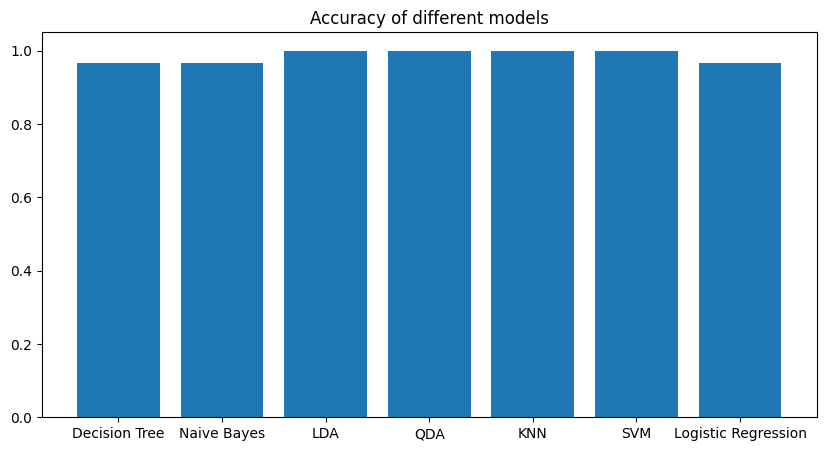

The best model is LDA with an accuracy of 1.00


In [3]:
iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df["target"] = iris.target

X, y = df.drop("target", axis=1), df["target"]

# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Create a list of classifiers
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=3, random_state=1),
    "Naive Bayes": GaussianNB(),
    "LDA": LinearDiscriminantAnalysis(),
    "QDA": QuadraticDiscriminantAnalysis(),
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(kernel="linear"),
    "Logistic Regression": LogisticRegression(),
}

# # Train the models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results[name] = metrics.accuracy_score(y_test, y_pred)

# Plot results
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values())
plt.title("Accuracy of different models")
plt.show()


# Print results
best_model = max(results, key=results.get)
print(f"The best model is {best_model} with an accuracy of {results[best_model]:.2f}")

# save the model to disk
pickle.dump(
    models[best_model], open(SKLEARN_MODEL_PATH, "wb")
)  # export the model to a file so we can use it later


# Train model using Tensorflow

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
train_dataset, metadata = tfds.load("iris", with_info=True, as_supervised=True, split="train", batch_size=32)
num_examples = metadata.splits["train"].num_examples
num_classes = metadata.features["label"].num_classes
labels = metadata.features["label"].names

2024-04-25 14:58:25.161136: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-04-25 14:58:25.161154: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-04-25 14:58:25.161157: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-04-25 14:58:25.161171: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-25 14:58:25.161188: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
num_examples

150

In [8]:
labels

['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']

In [9]:
num_classes

3

(32, 4)


2024-04-25 14:58:25.219216: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


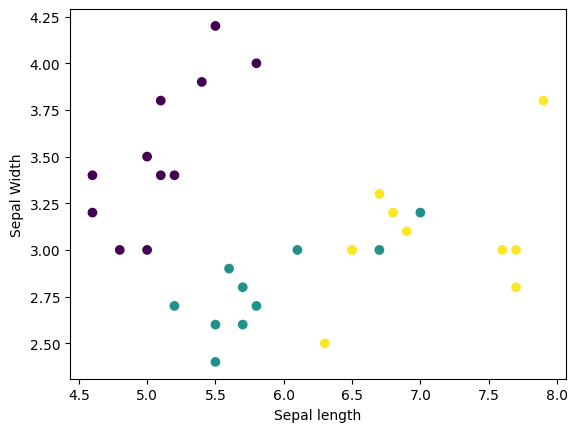

In [10]:
features, labels = next(iter(train_dataset))
sepal_length = features[:,0]
sepal_width = features[:,1]
print(features.shape)

plt.scatter(sepal_length,
            sepal_width,
            c=labels,
            cmap='viridis')
plt.xlabel("Sepal length")
plt.ylabel("Sepal Width")
plt.show()

In [11]:
model = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(4,), name="input"),
  tf.keras.layers.Dense(10, activation=tf.nn.relu), 
  tf.keras.layers.Dense(5, activation=tf.nn.relu),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(3, activation=tf.nn.softmax, name="output")
])

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (Dense)                   │ (None, 10)             │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5)              │            20 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 3)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 143 (572.00 B)

 Trainable params: 133 (532.00 B)

 Non-trainable params: 10 (40.00 B)

Epoch 1/50


2024-04-25 14:58:25.581243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1331 - loss: 1.5691
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3301 - loss: 1.2813
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4136 - loss: 1.1047
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4889 - loss: 1.0240 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5518 - loss: 0.9705 
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5747 - loss: 0.9293 
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6241 - loss: 0.8951 
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6303 - loss: 0.8659 
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6456 - loss: 0.8403
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7043 - loss: 0.8177 
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7174 - loss: 0.7973 
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7174 - loss: 0.7789 
Epoch 13/50
5

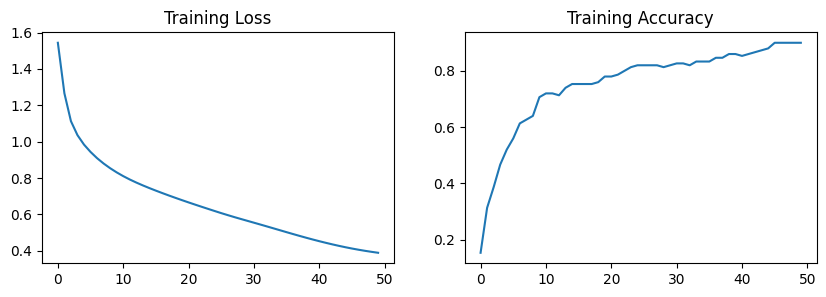

In [13]:
loss_fun = tf.keras.losses.SparseCategoricalCrossentropy()
opt_fun = tf.keras.optimizers.Adam()
model.compile(optimizer=opt_fun, loss=loss_fun, metrics=['accuracy'] )
history = model.fit(train_dataset, batch_size=12, epochs=50)

acc = history.history['accuracy']
loss = history.history['loss']
plt.figure(figsize=(10, 3))
ax = plt.subplot(1, 2, 1)
ax.set_title("Training Loss")
ax.plot(loss)
ax = plt.subplot(1, 2, 2)
ax.set_title("Training Accuracy")
ax.plot(acc)
plt.show()

In [17]:
predictions = model.predict(np.array([[0.5, 0.4, 0.8, 0.4]]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [18]:
predictions

array([[0.00962958, 0.98504746, 0.00532296]], dtype=float32)

In [22]:
model.save(TF_MODEL_PATH)